In [1]:
import dask
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

from dask_ml.preprocessing import Categorizer, OrdinalEncoder
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression
from dask_ml.metrics import mean_absolute_error

from lightgbm.dask import DaskLGBMRegressor

import os

In [2]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 5.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43271,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:41297,Total threads: 3
Dashboard: http://127.0.0.1:38261/status,Memory: 1.41 GiB
Nanny: tcp://127.0.0.1:43549,


In [4]:
path_to_csvs = "../datasample/sample.csv"
ddf_regions = dd.read_csv(path_to_csvs, blocksize="20MB")

In [5]:
ddf_regions.columns

Index(['Unnamed: 0', 'index', 'Data', 'Hora',
       'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'region', 'state', 'station',
       'station_code', 'latitude', 'longitude', 'height'],
      dtype='o

In [6]:
colunas_temperatura = [
    'TEMPERATURA DO PONTO DE ORVALHO (°C)',
    'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
    'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)'
]
target_column = 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'

In [7]:
ddf_regions = ddf_regions.drop(columns=colunas_temperatura)

In [8]:
ddf_regions.dtypes

Unnamed: 0                                                         int64
index                                                              int64
Data                                                     string[pyarrow]
Hora                                                     string[pyarrow]
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                                 float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)            float64
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)                  float64
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)                 float64
RADIACAO GLOBAL (Kj/m²)                                            int64
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                     float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                           int64
UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)                           int64
UMIDADE RELATIVA DO AR, HORARIA (%)                                int64
VENTO, DIREÇÃO HORARIA (gr) (° (gr))               

In [9]:
ddf_filtered = ddf_regions[ddf_regions[target_column] != -9999]

In [10]:
categorical_cols = [
    "Data",
    "Hora",
    "region",
    "state",
    "station",
    "station_code",
]

In [11]:
categorizer = Categorizer(columns=categorical_cols)
ddf_categorized = categorizer.fit_transform(ddf_filtered)

In [12]:
encoder = OrdinalEncoder()
ddf_encoded = encoder.fit_transform(ddf_categorized)

In [13]:
X = ddf_encoded.drop([target_column] + ["index"], axis=1)
y = ddf_encoded[target_column]

In [14]:
X.columns

Index(['Unnamed: 0', 'Data', 'Hora', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'region', 'state', 'station',
       'station_code', 'latitude', 'longitude', 'height'],
      dtype='object')

In [15]:
# split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [16]:
import dask.array as da

Xtr = Xtrain.to_dask_array(lengths=True)
Xts = Xtest.to_dask_array(lengths=True)
ytr = ytrain.to_dask_array(lengths=True)
yts = ytest.to_dask_array(lengths=True)

In [17]:
%%time
model = DaskLGBMRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    objective="regression",
    random_state=42,
    verbose=2
)

model.client = client
model.fit(Xtr, ytr, eval_set=[(Xtr, ytr)], eval_metric="auc")

/opt/conda/lib/python3.10/site-packages/lightgbm/dask.py:549: UserWarning: Parameter n_jobs will be ignored.
  _log_warning(f"Parameter {param_alias} will be ignored.")


Finding random open ports for workers
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.063372
[LightGBM] [Debug] init for col-wise cost 0.000460 seconds, init for row-wise cost 0.000507 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 3606
[LightGBM] [Info] Number of data points in the train set: 3582, number of used features: 21
[LightGBM] [Info] Start training from score 23.363847
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 7
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 8
[LightGBM

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.01
,n_estimators,1000
,subsample_for_bin,200000
,objective,'regression'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [18]:
%%time
# Predict (returns Dask array)
y_pred = model.predict(Xts)

CPU times: user 474 ms, sys: 9.81 ms, total: 484 ms
Wall time: 181 ms


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [19]:
%%time
mean_absolute_error(yts, y_pred)

CPU times: user 358 ms, sys: 31.2 ms, total: 390 ms
Wall time: 269 ms


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


np.float64(1.697200819382703)

In [20]:
yts[:10].compute().tolist(), y_pred[:10].compute().tolist()

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


([23.8, 16.7, 25.5, 30.7, 10.3, 21.1, 24.5, 18.8, 26.5, 26.7],
 [24.298810362970965,
  17.83083928194583,
  22.707055707985898,
  31.83599600905529,
  9.025747427955194,
  19.342307486366867,
  23.090922132107423,
  20.60888766505249,
  26.447280414281067,
  24.288516525583628])

In [21]:
model.feature_names_in_

array(['Column_0', 'Column_1', 'Column_2', 'Column_3', 'Column_4',
       'Column_5', 'Column_6', 'Column_7', 'Column_8', 'Column_9',
       'Column_10', 'Column_11', 'Column_12', 'Column_13', 'Column_14',
       'Column_15', 'Column_16', 'Column_17', 'Column_18', 'Column_19',
       'Column_20'], dtype='<U9')

In [22]:
X.columns

Index(['Unnamed: 0', 'Data', 'Hora', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)', 'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'region', 'state', 'station',
       'station_code', 'latitude', 'longitude', 'height'],
      dtype='object')

In [23]:
model.feature_importances_

array([1169, 5014, 1583,   53, 1615,  790,  828, 1219,  978,  744, 1776,
       1601, 1205,  996,  277,  300, 1052, 1055, 3180, 1270, 3295],
      dtype=int32)

In [24]:
colunas = X.columns.tolist()
importancias = model.feature_importances_.tolist()

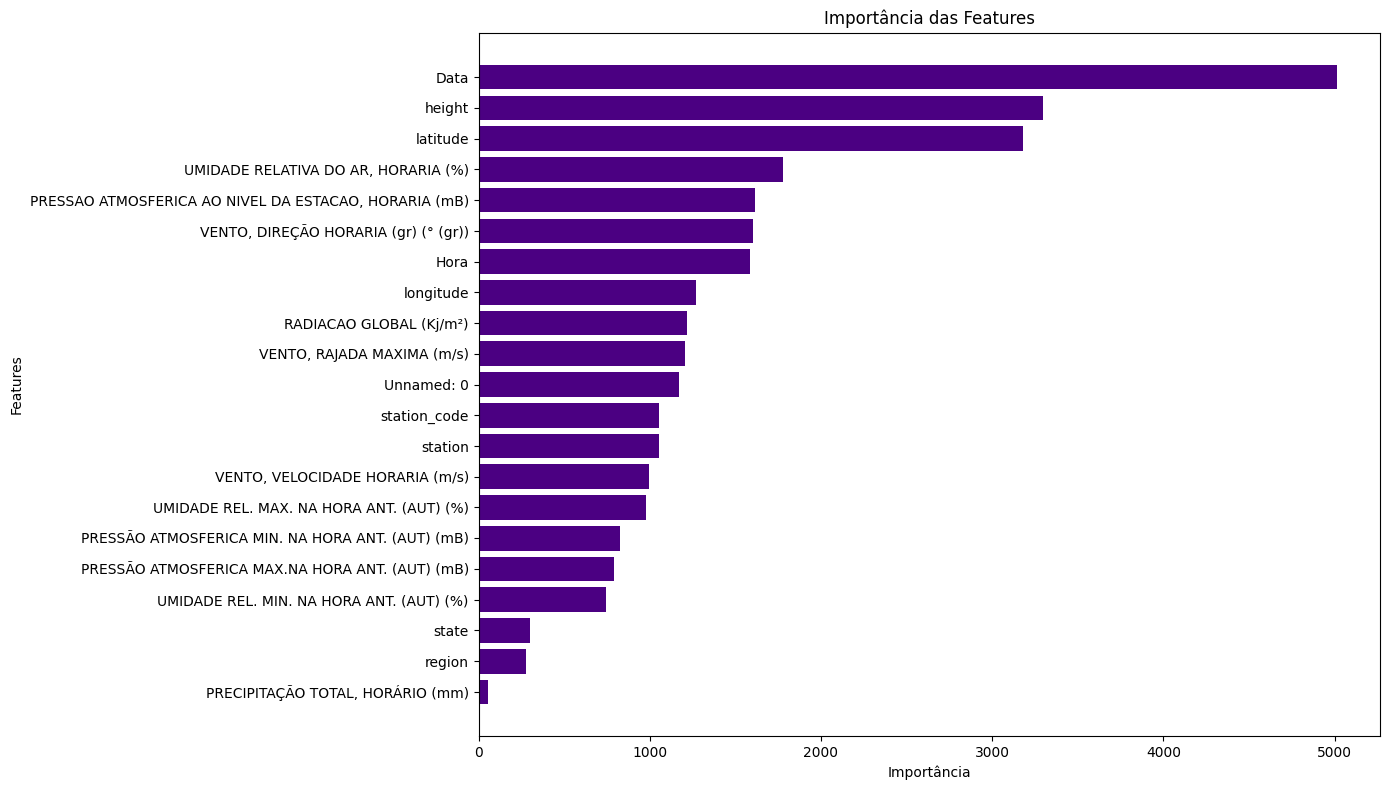

In [28]:
import matplotlib.pyplot as plt

colunas_importancia = sorted(zip(colunas, importancias), key=lambda x: x[1], reverse=True)
colunas, importancias = zip(*colunas_importancia)

plt.figure(figsize=(14, 8))
plt.barh(colunas, importancias, color='indigo')
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()